### Import Libraries

In [ ]:
pip install imbalanced-learn transformers torch scikit-learn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

### Read the test and train dataset from the checkpoint

In [2]:
train_df = pd.read_csv("../data/train_dataset.csv")

In [3]:
train_df.shape

(7269, 9)

## Data Preprocessing

In [4]:
# Get unique count of values in each column
unique_counts = train_df.apply(lambda x: x.nunique())
print("\nUnique Value Counts:")
print(unique_counts)


Unique Value Counts:
project_name                      7210
methodology_or_protocol            359
region                              13
voluntary_registry                   4
project_type_from_the_registry     106
project_developer                 2572
arborwaproject                       4
scope                                9
type                                78
dtype: int64


In [5]:
# Step 1: Identify duplicate project names
duplicate_projects = train_df[train_df.duplicated('project_name', keep=False)]
duplicate_projects

,project_name,methodology_or_protocol,region,voluntary_registry,project_type_from_the_registry,project_developer,arborwaproject,scope,type
31,Two Fiets Digester,CAR U.S. Livestock Protocol,North America,CAR,Livestock Gas Capture/Combustion,"Maas Energy Works, Inc.",No,Agriculture,Manure Methane Digester
82,Usak Wind Power Plant,ACM0002,Western Asia,VCS,Energy industries (renewable/non-renewable sou...,Aydem Yenilenebilir Enerji A.Ş.,No,Renewable Energy,Wind
127,Coolgas 2019-2,ARB Compliance Offset Protocol: Destruction of...,North America,ACR,Ozone Depleting Substances,A-Gas US Inc.,Compliance,Chemical Processes,Ozone Depleting Substances Recovery & Destruction
138,SPI Wildfire Reforestation Project #3,ARB Compliance Offset Protocol: U.S. Forest Pr...,North America,CAR,Reforestation - ARB Compliance,Sierra Pacific Industries,Compliance,Forestry & Land Use,Afforestation/Reforestation
147,Corinth Abandoned Mine Methane Recovery Project,ARB Compliance Offset Protocol: Mine Methane C...,North America,ACR,Coal Mine Methane,Keyrock Energy LLC,Compliance,Industrial & Commercial,Mine Methane Capture
...,...,...,...,...,...,...,...,...,...
6825,9 MW Wind Energy Farm at Jodhpur Rajasthan by HZL,AMS-I.D.,Southern Asia,VCS,Energy industries (renewable/non-renewable sou...,Hindustan Zinc Limited,No,Renewable Energy,Wind
6940,Finite Carbon - Brosnan Forest,ARB Compliance Offset Protocol: U.S. Forest Pr...,North America,CAR,Improved Forest Management - ARB Compliance,Norfolk Southern Railway Company,Compliance,Forestry & Land Use,Improved Forest Management
6951,Robeson County Landfill,ACM0001,North America,VCS,Waste handling and disposal,"3Degrees Group, Inc",No,Waste Management,Landfill Methane
7021,Alliance Dairy,CAR U.S. Livestock Protocol,North America,CAR,Livestock Gas Capture/Combustion,"3Degrees Group, Inc",No,Agriculture,Manure Methane Digester


In [6]:
duplicate_projects.shape

(117, 9)

### SMOTE to handle Data Imbalance of minority classes

## Identify the outliers from projectTypes

In [7]:

type_df = train_df["type"]
type_counts = type_df.value_counts().reset_index()
type_counts.columns = ["type", 'count']

type_counts


,type,count
0,Cookstoves,1166
1,Wind,831
2,Improved Forest Management,597
3,Hydropower,419
4,Afforestation/Reforestation,374
...,...,...
73,Improved irrigation management,1
74,Pneumatic Retrofit,1
75,Compost Addition to Rangeland,1
76,Grid Expansion & Mini-Grids,1


In [8]:
# Using ZScore to identify the outliers
from scipy.stats import zscore
# Calculate Z-scores for counts
type_counts['zscore'] = zscore(type_counts['count'])

# Identify outliers (e.g., Z-score > 2 or Z-score < -2)
outliers = type_counts[np.abs(type_counts['zscore']) > 2]

print("Outliers based on Z-score:")
print(outliers)

Outliers based on Z-score:
                         type  count    zscore
0                  Cookstoves   1166  5.659761
1                        Wind    831  3.892417
2  Improved Forest Management    597  2.657914


In [9]:
# Projects with types lower than 10 counts
type_counts = train_df["type"].value_counts()

# Identify the types with fewer than 10 counts
types_to_drop = type_counts[type_counts < 10].index
print(types_to_drop.shape)
# Drop the records with these types from train_df
train_df_new = train_df[~train_df["type"].isin(types_to_drop)]
print(train_df_new.shape)

(32,)
(7148, 9)


In [295]:
# Based on the Zscore, the major classes will be undersampled and minority classes will be oversample

In [10]:
X_train_df = train_df_new.drop(columns=['type', 'scope'])
Y_train_df = train_df_new['type']

In [11]:
print(X_train_df.shape)

(7148, 7)


In [12]:
## Splitting the train to train and validation sets
X_train, X_val, Y_train, Y_val  = train_test_split(X_train_df,Y_train_df, test_size=0.1, stratify =Y_train_df,  random_state=42)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape )

(6433, 7) (715, 7) (6433,) (715,)


## Encoding the categorical and text features


In [13]:
# Define categorical and text features
categorical_features = ['region', 'voluntary_registry', 'arborwaproject']
text_features = ['project_name','methodology_or_protocol','project_type_from_the_registry', 'project_developer']


In [18]:
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessor for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Preprocessor for text features
text_transformers = [(f'text_{i}', TfidfVectorizer(), col) for i, col in enumerate(text_features)]

# Combine all preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ] + text_transformers,
    remainder='passthrough'
)

# Define SMOTE and RandomUnderSampler
over_sampling = RandomOverSampler(random_state=42)
# sampling_strategy = {
#     'Cookstoves': 300,  
#     'Wind': 300,         
#     'Improved Forest Management': 300 
# }
#under_sampling = RandomUnderSampler(random_state=42)

# Pipeline for preprocessing and resampling
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
   # ('undersampling', under_sampling),
    ('oversampling', over_sampling)
])

# Apply preprocessing, SMOTE, and undersampling
X_resampled_combined, y_resampled = pipeline.fit_resample(X_train, Y_train)


In [19]:
print(X_resampled_combined.shape, y_resampled.shape)
print(X_resampled_combined.dtype)

(48254, 11309) (48254,)
float64


In [20]:
# Check the class distribution after resampling
resampledCounter = Counter(y_resampled)
originalCounter = Counter(Y_train_df)

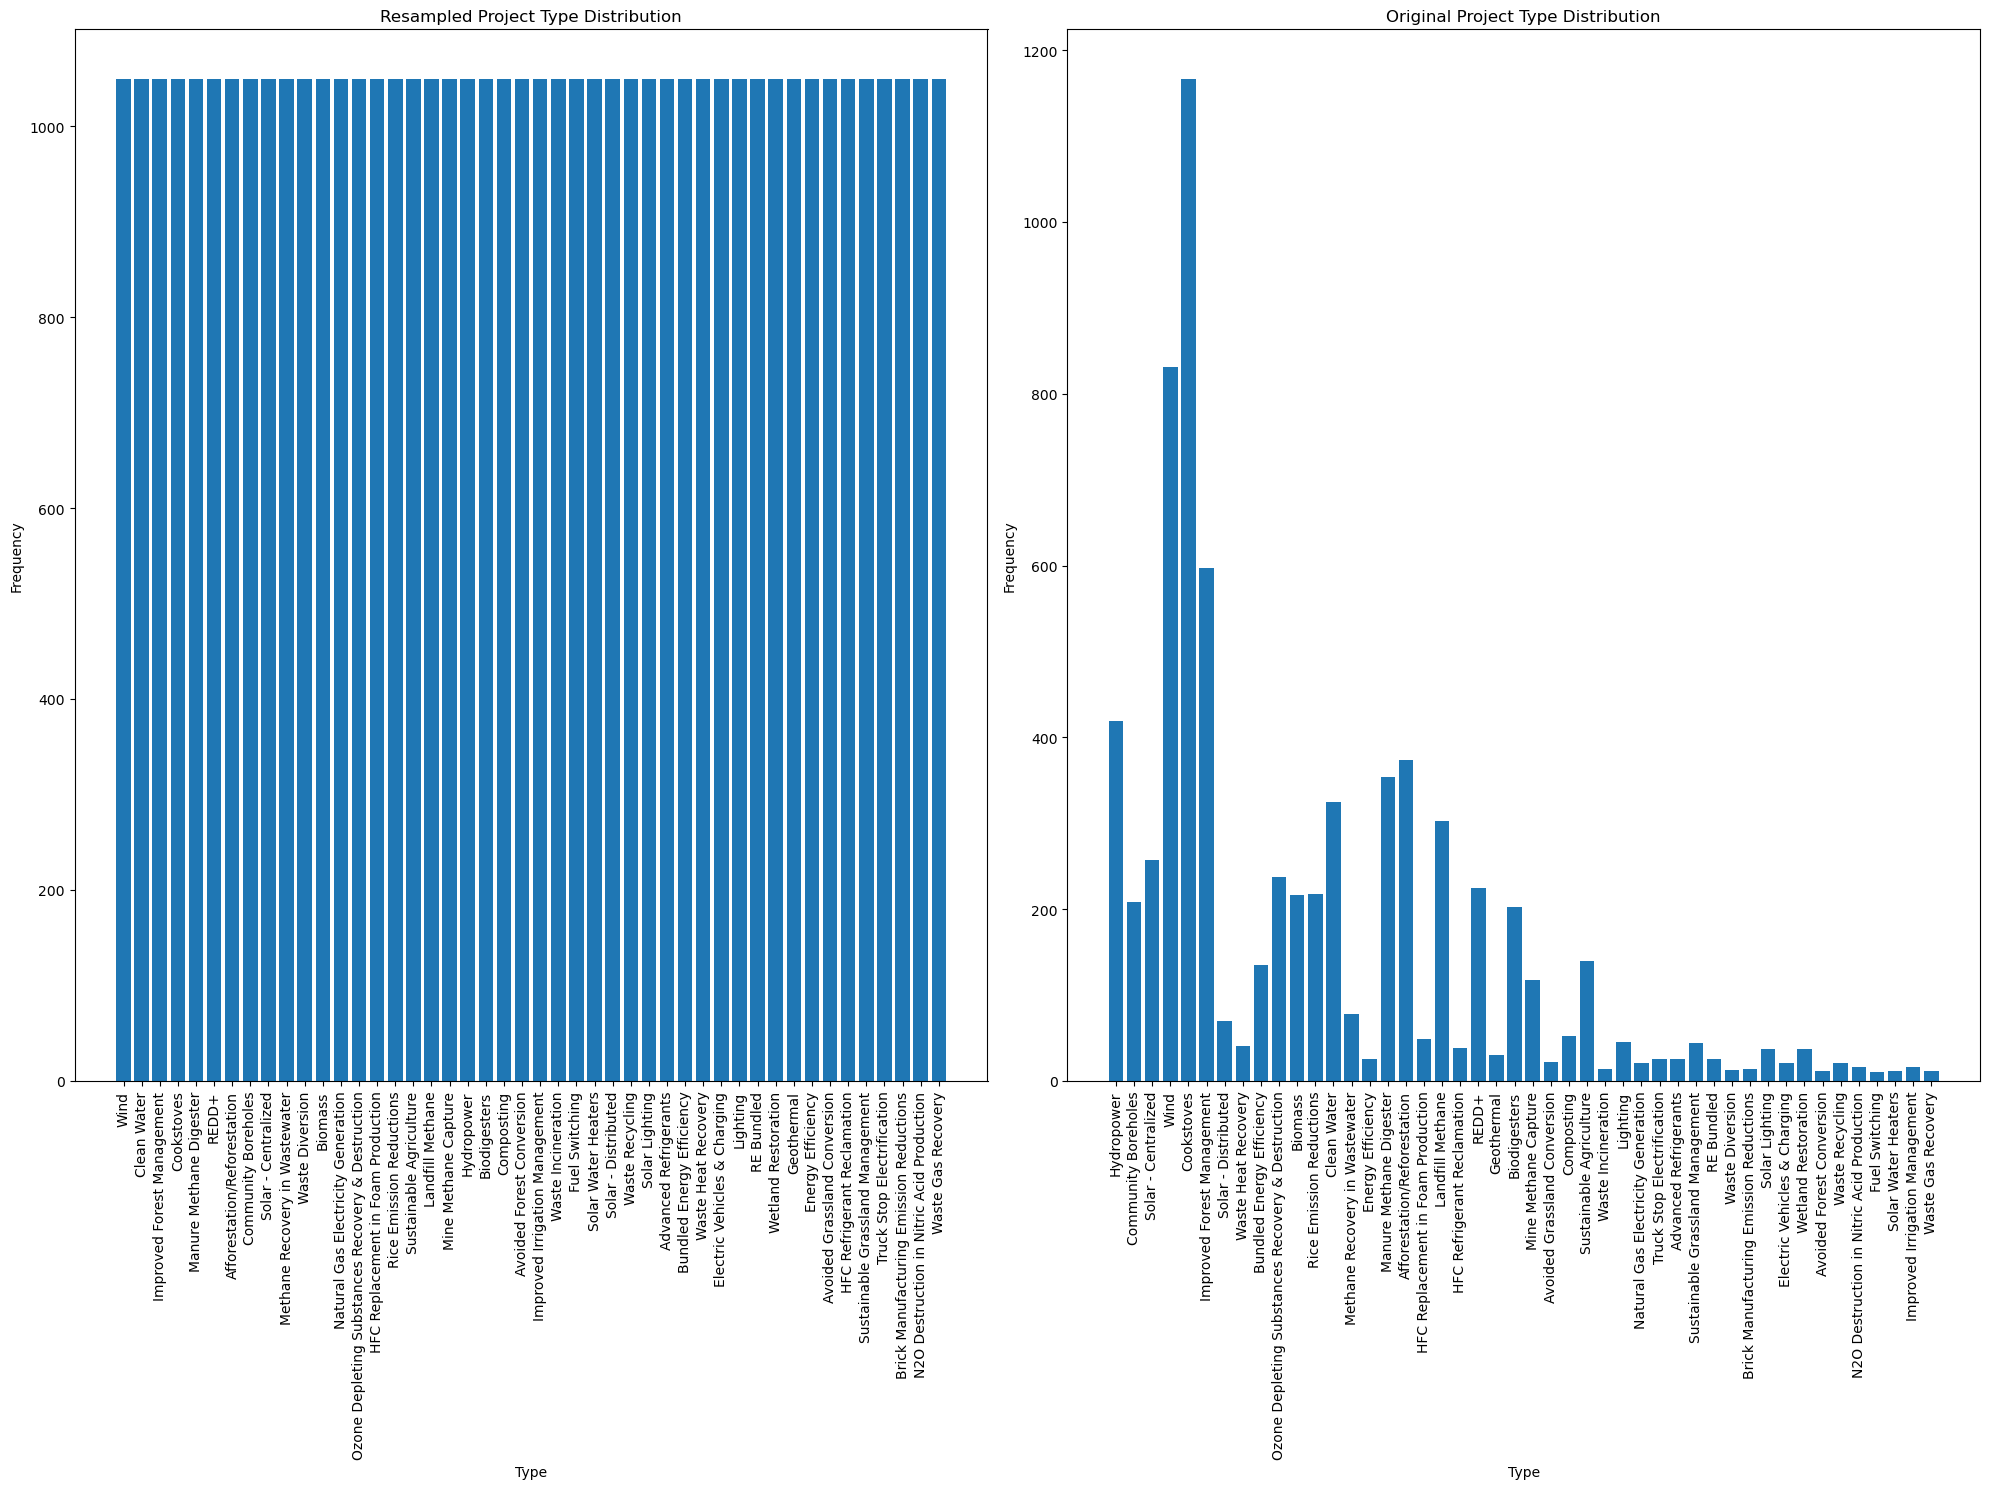

In [21]:
# Plotting histograms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))

# Resampled class distribution histogram
axes[0].bar(resampledCounter.keys(), resampledCounter.values())
axes[0].set_title('Resampled Project Type Distribution')
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(list(resampledCounter.keys()))
axes[0].set_xticklabels(resampledCounter.keys(), rotation=90)

# Original class distribution histogram
axes[1].bar(originalCounter.keys(), originalCounter.values())
axes[1].set_title('Original Project Type Distribution')
axes[1].set_xlabel('Type')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(list(originalCounter.keys()))
axes[1].set_xticklabels(originalCounter.keys(), rotation=90)

# Display the histograms
plt.tight_layout()
plt.show()


### Logistic Regression

In [31]:
# Define the logistic regression model
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)

# Fit the logistic regression model on the resampled data
logistic_regression.fit(X_resampled_combined, y_resampled)

# Make predictions on the val data

X_val_transformed = preprocessor.transform(X_val)
y_pred = logistic_regression.predict(X_val_transformed)

# Get the predicted probabilities for each class
y_pred_proba = logistic_regression.predict_proba(X_val_transformed)
# Evaluate the model and get the classification report
report = classification_report(Y_val, y_pred, output_dict=True)

# Convert the classification report to a DataFrame for a tabular format
report_df = pd.DataFrame(report).transpose()

# Display the classification report table
report_df

/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,precision,recall,f1-score,support
Advanced Refrigerants,1.000000,1.000000,1.000000,3.000000
Afforestation/Reforestation,1.000000,0.972973,0.986301,37.000000
Avoided Forest Conversion,1.000000,1.000000,1.000000,1.000000
Avoided Grassland Conversion,1.000000,1.000000,1.000000,2.000000
Biodigesters,0.952381,1.000000,0.975610,20.000000
Biomass,0.857143,0.818182,0.837209,22.000000
Brick Manufacturing Emission Reductions,0.500000,1.000000,0.666667,1.000000
Bundled Energy Efficiency,0.833333,0.714286,0.769231,14.000000
Clean Water,0.968750,0.939394,0.953846,33.000000
Community Boreholes,0.954545,1.000000,0.976744,21.000000


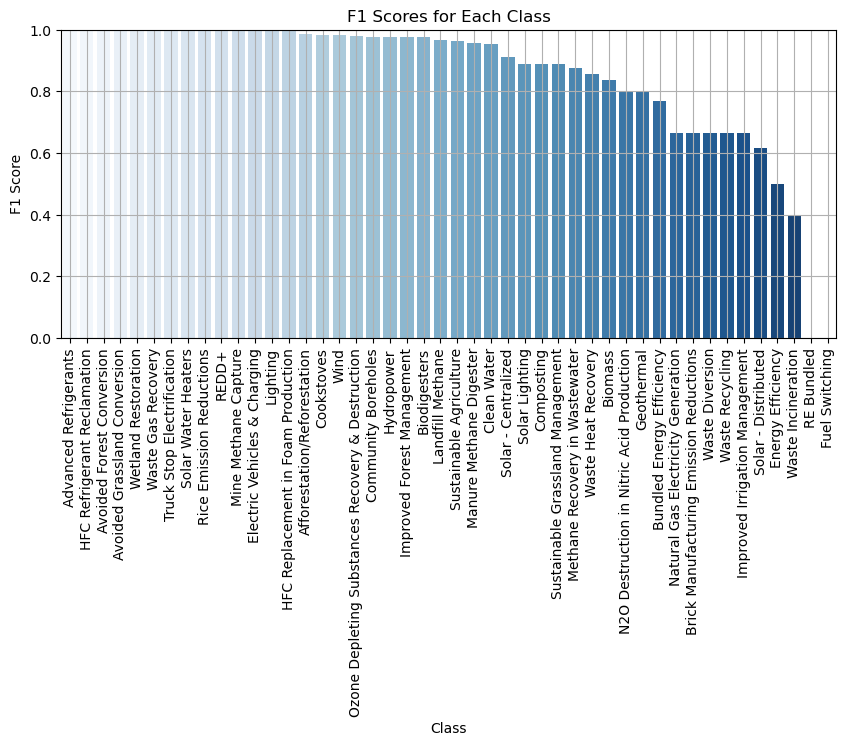

In [24]:
import seaborn as sns
# Extract F1 scores from the classification report
f1_scores = {key: value['f1-score'] for key, value in report.items() if key not in ('accuracy', 'macro avg', 'weighted avg')}

# Convert the F1 scores to a DataFrame for plotting
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Class', 'F1 Score'])

# Sort the DataFrame by F1 Score in ascending order
f1_df = f1_df.sort_values(by='F1 Score', ascending = False)

# Plot the F1 scores
plt.figure(figsize=(10, 4))
sns.barplot(x='Class', y='F1 Score', data=f1_df, palette='Blues')
plt.title('F1 Scores for Each Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=90)  # Rotate x-ticks by 90 degrees
plt.grid(True)
plt.show()

In [26]:
## Check all the incorrect predictions

In [38]:
# Create a DataFrame to compare true labels and predictions
comparison_df = pd.DataFrame({
    'True Label': Y_val,
    'Predicted Label': y_pred,
    'Correct Prediction': Y_val == y_pred
})
# Concatenate the input features with the comparison DataFrame
comparison_df = pd.concat([X_val.reset_index(drop=True), comparison_df.reset_index(drop=True)], axis=1)

# Display the DataFrame with incorrect predictions
incorrect_predictions = comparison_df[~comparison_df['Correct Prediction']]
print(incorrect_predictions.shape)
incorrect_predictions

(35, 10)


,project_name,methodology_or_protocol,region,voluntary_registry,project_type_from_the_registry,project_developer,arborwaproject,True Label,Predicted Label,Correct Prediction
25,Waste to Energy Projects by Mahindra Waste to ...,ACM0022,Southern Asia,VCS,Energy industries (renewable/non-renewable sou...,MAHINDRA WASTE TO ENERGY SOLUTIONS LTD.,No,Biomass,Waste Incineration,False
33,International Programme for Safe Water Access ...,GS TPDDTEC v3.1,Sub-Saharan Africa,GOLD,Energy Efficiency - Domestic,CO2balance UK ltd,No,Bundled Energy Efficiency,Clean Water,False
46,LA PERSEVERANCIA BIOGAS PLANT,CAR Mexico Landfill Protocol,Latin America and the Caribbean,CAR,Landfill - MX,Energía Renovable de Cuautla S.A. de C.V.,No,Landfill Methane,Improved Forest Management,False
63,BASMAKCI BIOGAS POWER PLANT PROJECT,AMS-I.C. Thermal energy production with or wit...,Western Asia,GOLD,Biogas - Electricity,Cagla Balci Eris,No,Biomass,Manure Methane Digester,False
66,Renewable Power Project by SEI Kathiravan Powe...,ACM0002,Southern Asia,VCS,Energy industries (renewable/non-renewable sou...,SEI Kathiravan Power Private Limited,No,RE Bundled,Solar - Centralized,False
85,Water and Climate – Multi-country PoA,GS Methodology for emission reductions from sa...,Southern Asia,GOLD,Energy Efficiency - Domestic,Helioz GmbH,No,Clean Water,Bundled Energy Efficiency,False
97,"NATURE PANELS, GABON",AM0057; Methodology Under Development,Sub-Saharan Africa,VCS,Waste handling and disposal,ARISE IIP,No,Waste Recycling,Waste Diversion,False
106,Green Energy Project at Gujarat by Powerica Li...,ACM0002,Southern Asia,VCS,Energy industries (renewable/non-renewable sou...,POWERICA LIMITED,No,RE Bundled,Wind,False
125,Renewable Power Project by the Kiran Group (EK...,AMS-I.D. Grid connected renewable electricity ...,Southern Asia,GOLD,Wind,EKI Energy Services Limited,No,RE Bundled,Wind,False
127,cancelled duplicate of VCSR218,ACM0002,Eastern Asia,VCS,Energy industries (renewable/non-renewable sou...,MER,No,Wind,Hydropower,False


In [29]:
## Confidence level of the result

In [37]:
# Create a DataFrame to compare true labels and predictions with confidence levels
comparison_df = pd.DataFrame({
    'True Label': Y_val,
    'Predicted Label': y_pred,
    'Confidence Level': [max(proba) for proba in y_pred_proba],
    'Correct Prediction': Y_val == y_pred
})
# Concatenate the input features with the comparison DataFrame
comparison_df = pd.concat([X_val.reset_index(drop=True), comparison_df.reset_index(drop=True)], axis=1)

# Display the DataFrame with correct predictions and their confidence levels
correct_predictions = comparison_df[comparison_df['Correct Prediction']]
correct_predictions

,project_name,methodology_or_protocol,region,voluntary_registry,project_type_from_the_registry,project_developer,arborwaproject,True Label,Predicted Label,Confidence Level,Correct Prediction
0,Bundled Wind Project Activity by M/s Bhagyanag...,AMS-I.D.,Southern Asia,VCS,Energy industries (renewable/non-renewable sou...,Multiple Proponents,No,Wind,Wind,0.852447,True
1,BioLite Improved Cook stoves Programme - CER C...,AMS-II.G.,Sub-Saharan Africa,VCS,Energy demand,Converted from other GHG program,No,Cookstoves,Cookstoves,0.957106,True
2,Northern Great Plains Regenerative Grazing Pro...,VM0026,North America,VCS,Agriculture Forestry and Other Land Use,"Native, a Public Benefit Corporation",No,Sustainable Grassland Management,Sustainable Grassland Management,0.948224,True
3,Everbright Zhenjiang Bundled Solar PV Power Ge...,AMS-I.D. Grid connected renewable electricity ...,Eastern Asia,GOLD,Solar Thermal - Electricity,Innovative Carbon Investment Co. Ltd.,No,Solar - Centralized,Solar - Centralized,0.952790,True
4,GS1264: NativeEnergy Clean Water Programme Wes...,GS TPDDTEC v 1.,Sub-Saharan Africa,GOLD,Energy Efficiency - Domestic,NativeEnergy Inc.,No,Clean Water,Clean Water,0.826448,True
...,...,...,...,...,...,...,...,...,...,...,...
710,Biodigesters program for a low-carbon livestoc...,GS TPDDTEC v3.1,South-Eastern Asia,GOLD,Biogas - Heat,Nexus-Carbon for Development,No,Biodigesters,Biodigesters,0.817217,True
711,Martinsville Methane Collection Project,CAR U.S. Landfill Protocol,North America,CAR,Landfill Gas Capture/Combustion,City of Martinsville,No,Landfill Methane,Landfill Methane,0.965967,True
712,GS11324 - VPA004 - Congo (DRC) Improved Cook S...,GS TPDDTEC V4.0: REDUCED EMISSIONS FROM COOKIN...,Sub-Saharan Africa,GOLD,Energy Efficiency - Domestic,Vitol SA,No,Cookstoves,Cookstoves,0.900594,True
713,EOS ACR 252,ARB Compliance Offset Protocol: Destruction of...,North America,ACR,Ozone Depleting Substances,EOS Climate Inc,Compliance,Ozone Depleting Substances Recovery & Destruction,Ozone Depleting Substances Recovery & Destruction,0.999236,True


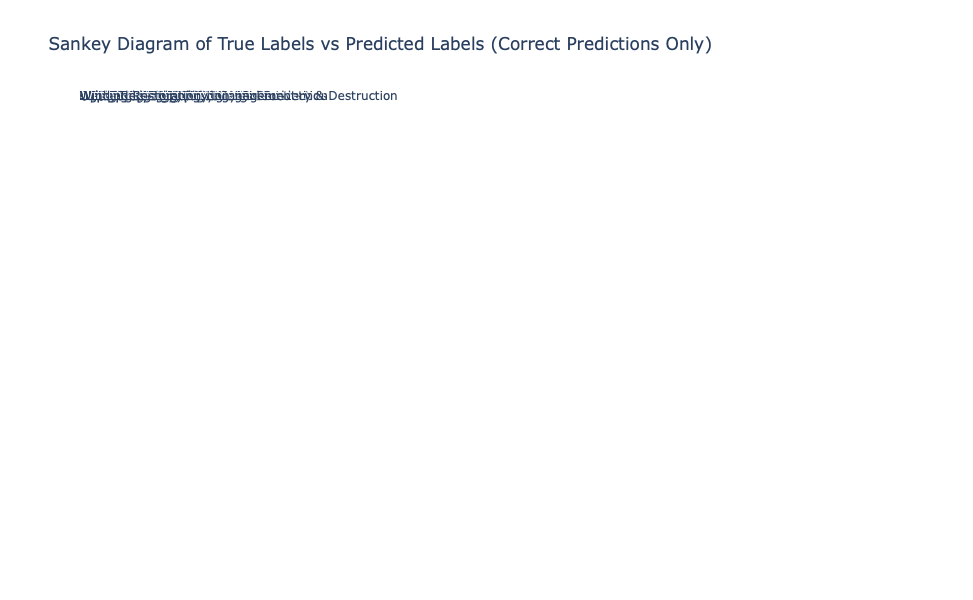

In [44]:
import plotly.graph_objects as go


# Prepare data for the Sankey plot
true_labels = correct_predictions['True Label']
pred_labels = correct_predictions['Predicted Label']

# Create a list of unique labels from both true and predicted labels
label_list = list(set(true_labels) | set(pred_labels))
label_list.sort()

# Create a dictionary to map labels to indices
label_dict = {label: i for i, label in enumerate(label_list)}

# Convert labels to indices
source_indices = [label_dict[label] for label in true_labels]
target_indices = [label_dict[label] for label in pred_labels]

# Count occurrences of each pair (source, target)
flow_data = pd.DataFrame({'source': source_indices, 'target': target_indices})
flow_data['count'] = 1
flow_data = flow_data.groupby(['source', 'target'], as_index=False).count()

# Create the Sankey plot with larger size and adjusted properties
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=30,
        line=dict(color="black", width=0.5),
        label=label_list,
        color="blue"
    ),
    link=dict(
        source=flow_data['source'],
        target=flow_data['target'],
        value=flow_data['count'],
        color="rgba(31, 119, 180, 0.5)"
    )
)])

fig.update_layout(
    title_text="Sankey Diagram of True Labels vs Predicted Labels (Correct Predictions Only)",
    font_size=12,
    width=1000,  # Increase the width
    height=600,  # Increase the height
)

fig.show()